# Lateral offset analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from substitutors import *
from filters import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
mouseline = 'sst' # Mouse line
layer = None  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
baseline_wlen = BASELINE_WLEN  # length of rolling window for baseline computation
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile in folling window for baseline evaluation
baseline_smoothing = BASELINE_SMOOTHING   # whether to smooth the baseline with an extra moving average
ykey_postpro = Label.DFF  # variable of interest for post-processing
include_patterns = SST_OFFSET_DATASETS

### Derived parameters

In [4]:
dataroot = get_data_root()
figsdir = get_output_equivalent(dataroot, 'raw', 'figs')
trialavg_root = get_output_equivalent(dataroot, 'raw', 'trial-averaged')
# Construct dataset group ID
dataset_group_id = f'{mouseline}_offset'
if layer is not None:
    dataset_group_id = f'{dataset_group_id}_{layer}'
# Construct post-processing ID
if baseline_wlen is None:
    baseline_smoothing = False
    baseline_id = ''
else:
    baseline_id = f'w{baseline_wlen:.1f}s'
baseline_id = f'{baseline_id}_q{baseline_quantile:.2f}'
if baseline_smoothing:
    baseline_id = f'{baseline_id}_smooth'
postpro_id = f'{baseline_id}_{ykey_postpro}'.replace('/', '')
# Get figures PDF suffix
figs_suffix = f'{dataset_group_id}_k{kalman_gain}_{postpro_id}'
# Get trial-averaged input data directory
submap = [(1, 0), (FrameIndex.STIM - 1, FrameIndex.STIM)]
ss = StackSubstitutor(submap, repeat_every=NFRAMES_PER_TRIAL)
kd = KalmanDenoiser(kalman_gain) if kalman_gain > 0 else NoFilter
trialavg_dir = os.path.join(trialavg_root, baseline_id, kd.code, ss.code, mouseline)

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} batch notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 03/10/2022 18:25:42: sst_offset batch notebook started on 2022-10-03 at 18:25:42


### Input summary table figure

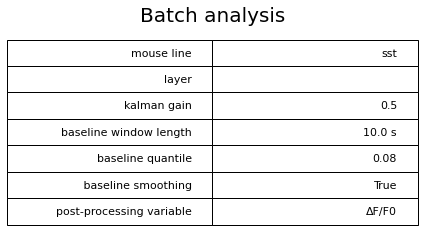

In [5]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'kalman gain': kalman_gain,
    'baseline window length': f'{baseline_wlen:.1f} s',
    'baseline quantile': baseline_quantile,
    ' baseline smoothing': baseline_smoothing,
    'post-processing variable': ykey_postpro
    }, title='Batch analysis')

## Input data

### Load data

In [6]:
# Determine what to do in case of duplicate runs
on_duplicate_runs = 'pass'

# Load datasets
logger.info(f'loading data from {trialavg_dir}:')
data = load_trialavg_datasets(
    trialavg_dir, layer=layer, include_patterns=include_patterns, include_mode='any',
    on_duplicate_runs=on_duplicate_runs, condition='offset')


 03/10/2022 18:25:42: loading data from /Users/tlemaire/Documents/data/usnm/trial-averaged/w10.0s_q0.08_smooth/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/sst:
 03/10/2022 18:25:42: excluding datasets not having any of the following patterns:
 - 20190518_mouse6_region1
 - 20190518_mouse7_region1
 - 20190601_mouse2_region1
 - 20190601_mouse7_region1
 - 20190601_mouse8_region1
 03/10/2022 18:25:42: loading trial-averaged data from 20190518_mouse6_region1.h5
 03/10/2022 18:25:42: loading trial-averaged data from 20190518_mouse7_region1.h5
 03/10/2022 18:25:42: loading trial-averaged data from 20190601_mouse2_region1.h5
 03/10/2022 18:25:42: loading trial-averaged data from 20190601_mouse7_region1.h5
 03/10/2022 18:25:42: loading trial-averaged data from 20190601_mouse8_region1.h5
 03/10/2022 18:25:42: gathering dataset IDs...
 03/10/2022 18:25:42: duplicated runs in 20190518_mouse7_region1:
run
1    1.5
2    1.5
Name: offset (mm), dtype: float64
 03/10/2022 18:25:42: duplicated runs in

### Breakdown per mouse region, cell maps & filter out datasets

 03/10/2022 18:28:24: extracting timeseries and stats from data...
 03/10/2022 18:28:24: plotting cells map color-coded by response type...
 03/10/2022 18:28:24: extracting responses types per ROI...
 03/10/2022 18:28:24: plotting cells map color-coded by response type...
 03/10/2022 18:28:24: extracting responses types per ROI...
 03/10/2022 18:28:25: plotting cells map color-coded by response type...
 03/10/2022 18:28:25: extracting responses types per ROI...
 03/10/2022 18:28:25: plotting cells map color-coded by response type...
 03/10/2022 18:28:25: extracting responses types per ROI...
 03/10/2022 18:28:27: plotting cells map color-coded by response type...
 03/10/2022 18:28:27: extracting responses types per ROI...
 03/10/2022 18:28:27: setting minimum cell count of 101 as inclusion criterion
 03/10/2022 18:28:27: ['20190808_mouse6_region1'] datasets not found -> ignoring
 03/10/2022 18:28:27: did not find any datasets to exclude


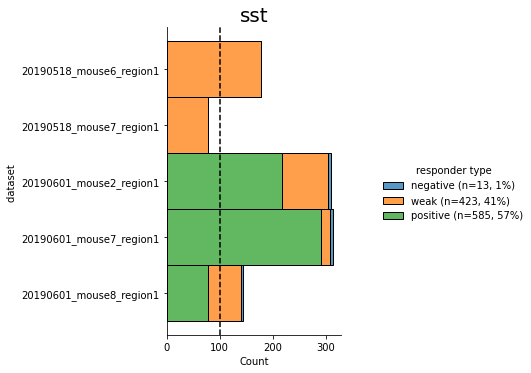

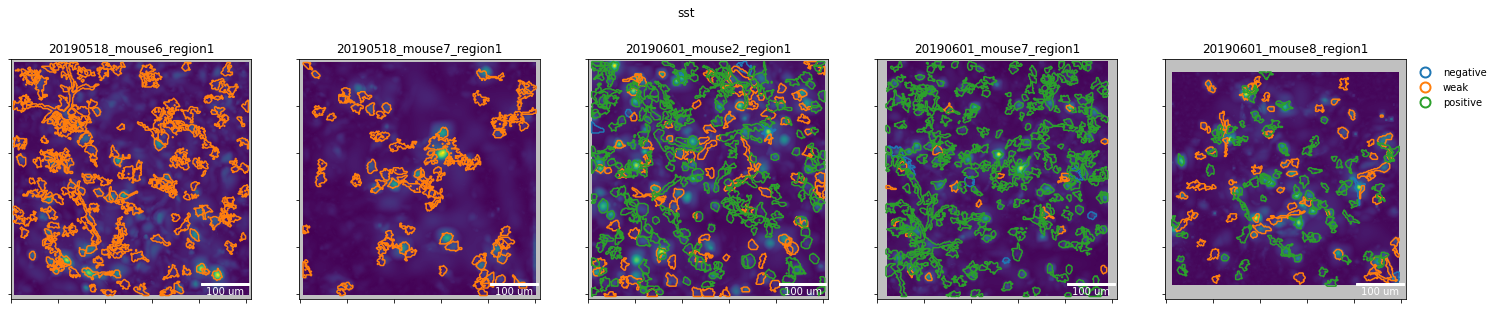

In [13]:
logger.info('extracting timeseries and stats from data...')
timeseries, stats, ROI_masks, map_ops = data['timeseries'], data['stats'], data['ROI_masks'], data['map_ops']

# Adding parsed offset info to stats
stats[Label.OFFSET] = stats[Label.SUFFIX].apply(parse_offset)

# Compute cell count threshold
um_per_px = 1.96  # from Bruker microscope
npx_per_line = 256  # from Bruker miscroscope
area = (um_per_px * npx_per_line)**2 / 1e6  # mm2
min_cell_count = int(np.round(MIN_CELL_DENSITY[mouseline] * area))

# Plot breakdown
figs['rtype dist per mousereg'] = plot_cellcounts_by_type(
    stats, hue=Label.ROI_RESP_TYPE, countref=min_cell_count,
    title=mouseline)

figs['cellmaps'] = plot_cell_maps(
        ROI_masks, stats, map_ops, title=mouseline, refkey='Vcorr', mode='contour')

# Idendify datasets with a low overall cell count
logger.info(f'setting minimum cell count of {min_cell_count} as inclusion criterion')
cells = stats.groupby([Label.DATASET, Label.ROI]).first()
cellcounts = cells.groupby(Label.DATASET).count().iloc[:, 0].rename('cell count')
weaks = cells.loc[cells[Label.ROI_RESP_TYPE] == 'weak']
weakcounts = weaks.groupby(Label.DATASET).count().iloc[:, 0].rename('weak count')
pctresp = (1 - (weakcounts / cellcounts)) * 100
count_exclude = cellcounts.loc[cellcounts < min_cell_count].index.values.tolist()
count_exclude = []
# Manual exclusions
manual_exclude = {
    'line3': [], #'20191109_mouse7_region2'
    'sst': ['20190808_mouse6_region1'],
    'pv': []
}[mouseline]

# Exclude them
timeseries, stats = exclude_datasets(timeseries, stats, count_exclude + manual_exclude)

In [16]:
stats

line  trial_length  PRF (Hz)  duration (s)  \
dataset                 ROI run                                              
20190518_mouse6_region1 0   0    sst         100.0     100.0           0.2   
                            1    sst         100.0     100.0           0.2   
                        1   0    sst         100.0     100.0           0.2   
                            1    sst         100.0     100.0           0.2   
                        2   0    sst         100.0     100.0           0.2   
...                              ...           ...       ...           ...   
20190601_mouse8_region1 363 2    sst         100.0     100.0           0.2   
                            3    sst         100.0     100.0           0.2   
                            3    sst         100.0     100.0           0.2   
                            4    sst         100.0     100.0           0.2   
                            4    sst         100.0     100.0           0.2   

                                  fps  P (MPa)  DC (%)  run ID       suffix  \
dataset                 ROI run                                               
20190518_mouse6_region1 0   0    3.56      0.8    50.0   663.0       center   
                            1    3.56      0.8    50.0   666.0   left_1.5mm   
                        1   0    3.56      0.8    50.0   663.0       center   
                            1    3.56      0.8    50.0   666.0   left_1.5mm   
                        2   0    3.56      0.8    50.0   663.0       center   
...                               ...      ...     ...     ...          ...   
20190601_mouse8_region1 363 2    3.56      0.8    50.0    39.0  right_0.5mm   
                            3    3.56      0.8    50.0    45.0  left_1.0mm_   
                            3    3.56      0.8    50.0    40.0  right_1.0mm   
                            4    3.56      0.8    50.0    47.0  left_2.0mm_   
                            4    3.56      0.8    50.0    42.0  right_2.0mm   

                                 I_SPPA (W/cm2)  ...  \
dataset                 ROI run                  ...   
20190518_mouse6_region1 0   0         19.784475  ...   
                            1         19.784475  ...   
                        1   0         19.784475  ...   
                            1         19.784475  ...   
                        2   0         19.784475  ...   
...                                         ...  ...   
20190601_mouse8_region1 363 2         19.784475  ...   
                            3         19.784475  ...   
                            3         19.784475  ...   
                            4         19.784475  ...   
                            4         19.784475  ...   

                                 post-stim avg ΔF/F0 - pre-stim avg ΔF/F0 pval  \
dataset                 ROI run                                                  
20190518_mouse6_region1 0   0                                         0.000304   
                            1                                         0.000056   
                        1   0                                         0.021374   
                            1                                         0.093049   
                        2   0                                         0.046488   
...                                                                        ...   
20190601_mouse8_region1 363 2                                         0.083826   
                            3                                         0.009677   
                            3                                         0.322421   
                            4                                         0.194405   
                            4                                         0.718201   

                                 response type  negative  positive  weak  \
dataset                 ROI run                                            
20190518_mouse6_region1 0   0         neg

In [22]:
stats.columns

Index(['line', 'trial_length', 'PRF (Hz)', 'duration (s)', 'fps', 'P (MPa)',
       'DC (%)', 'run ID', 'suffix', 'I_SPPA (W/cm2)', 'I_SPTA (W/cm2)',
       'peak displacement velocity (um/s)', 'max pre-stim Z(ΔF/F0)',
       'min pre-stim Z(ΔF/F0)', 'pre-stimulus outlier?', 'pre-stim avg ΔF/F0',
       'post-stim avg ΔF/F0', 'post-stim avg ΔF/F0 - pre-stim avg ΔF/F0',
       'post-stim avg ΔF/F0 - pre-stim avg ΔF/F0 tstat',
       'post-stim avg ΔF/F0 - pre-stim avg ΔF/F0 pval', 'response type',
       'negative', 'positive', 'weak', 'responder type',
       'pre-stim avg Z(ΔF/F0)', 'post-stim avg Z(ΔF/F0)',
       'post-stim avg Z(ΔF/F0) - pre-stim avg Z(ΔF/F0)', 'offset (mm)'],
      dtype='object')

In [24]:
ykey = ykey_postpro
ykey_pre = f'pre-stim avg {ykey}'
ykey_post = f'post-stim avg {ykey}'
ykey_diff = f'{ykey_post} - {ykey_pre}'
sns.lineplot(stats, x=Label.OFFSET, y=ykey_diff)

/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: Could not interpret value `post-stim avg ΔF/F0 - pre-stim avg ΔF/F0` for parameter `y`